In [1]:
# Dodane przez KS
import os
import sys
sys.path.append('..')
from src.data import load_dataset

In [1]:
from src.data import load_dataset

ModuleNotFoundError: No module named 'src'

In [2]:
X, y = load_dataset()

# Dodane przez KS
y = y.apply(lambda val: 1 if '>50K' in val else 0)

In [3]:
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

In [4]:
feature_names = X.columns.tolist()

## Las losowy

Właściwa część zaczyna się tu.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Dodane przez KS
import joblib
import os

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train.to_numpy(), y_train)

# Dodane przez KS

os.makedirs('../models', exist_ok=True)
joblib.dump(rf, '../models/rf_model.pkl')

y_pred = rf.predict(X_test.to_numpy())
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average = 'weighted')
print(f"Average Precision: {precision:.2f}")
print(f"Average Recall: {recall:.2f}")
print(f"Average F1-Score: {f1:.2f}")

Average Precision: 0.84
Average Recall: 0.85
Average F1-Score: 0.85


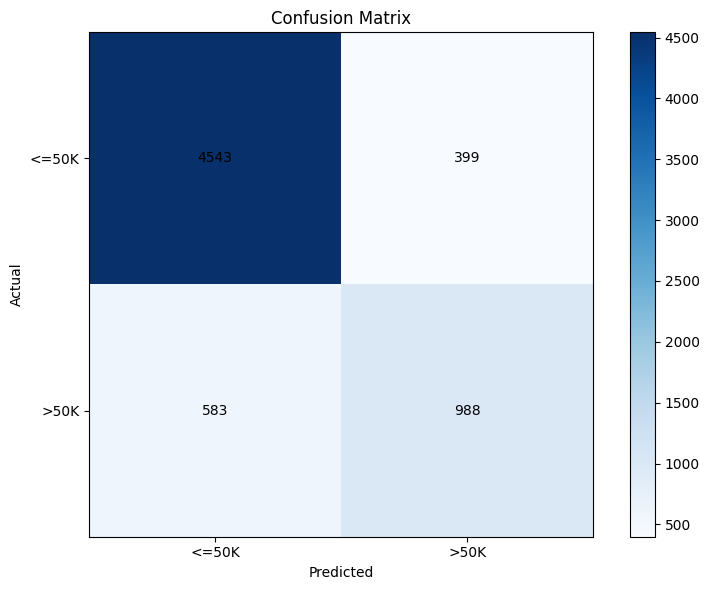

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['<=50K', '>50K']))
plt.xticks(tick_marks, ['<=50K', '>50K'])
plt.yticks(tick_marks, ['<=50K', '>50K'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='black')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## ALE

In [9]:
from alibi.explainers import ALE
import numpy as np
import pandas as pd

# Define predict function returning probabilities
def predict_fn(x):
    if isinstance(x, np.ndarray):
        x = pd.DataFrame(x, columns=feature_names)
    return rf.predict_proba(x)[:, 1]  # Probability of positive class

# Initialize ALE
ale = ALE(predictor=predict_fn, feature_names=feature_names)

# Run ALE (can pass DataFrame directly)
explanation = ale.explain(X_test.to_numpy())

# Show ALE summary
for i, fname in enumerate(feature_names):
    print(f"\nFeature: {fname}")
    print(f"  ALE Values: {explanation.ale_values[i][:5]}")
    print(f"  Feature Values: {explanation.feature_values[i][:5]}")

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2


Feature: age
  ALE Values: [[-0.11859658]
 [-0.11859658]
 [-0.11859658]
 [-0.11885973]
 [-0.11885973]]
  Feature Values: [17. 18. 19. 20. 21.]

Feature: education_num
  ALE Values: [[-0.07168604]
 [-0.07077695]
 [-0.07655652]
 [-0.08009434]
 [-0.07805231]]
  Feature Values: [1. 2. 3. 4. 5.]

Feature: capital-gain
  ALE Values: [[-0.04683467]
 [-0.04947642]
 [-0.04804785]
 [-0.04804785]
 [-0.04783951]]
  Feature Values: [   0.          594.         1797.         2176.         2532.15223881]

Feature: capital-loss
  ALE Values: [[-0.00720819]
 [-0.0195025 ]
 [-0.00994367]
 [-0.01105478]
 [-0.02438812]]
  Feature Values: [   0.          945.48910891 1485.         1573.59405941 1601.95247525]

Feature: hours-per-week
  ALE Values: [[-0.04282798]
 [-0.04532798]
 [-0.04532798]
 [-0.04125391]
 [-0.04239677]]
  Feature Values: [ 1.          5.70731707  8.         10.         12.        ]

Feature: marital-status_ Married-AF-spouse
  ALE Values: [[-0.01315378]
 [ 0.01315378]]
  Feature Values:

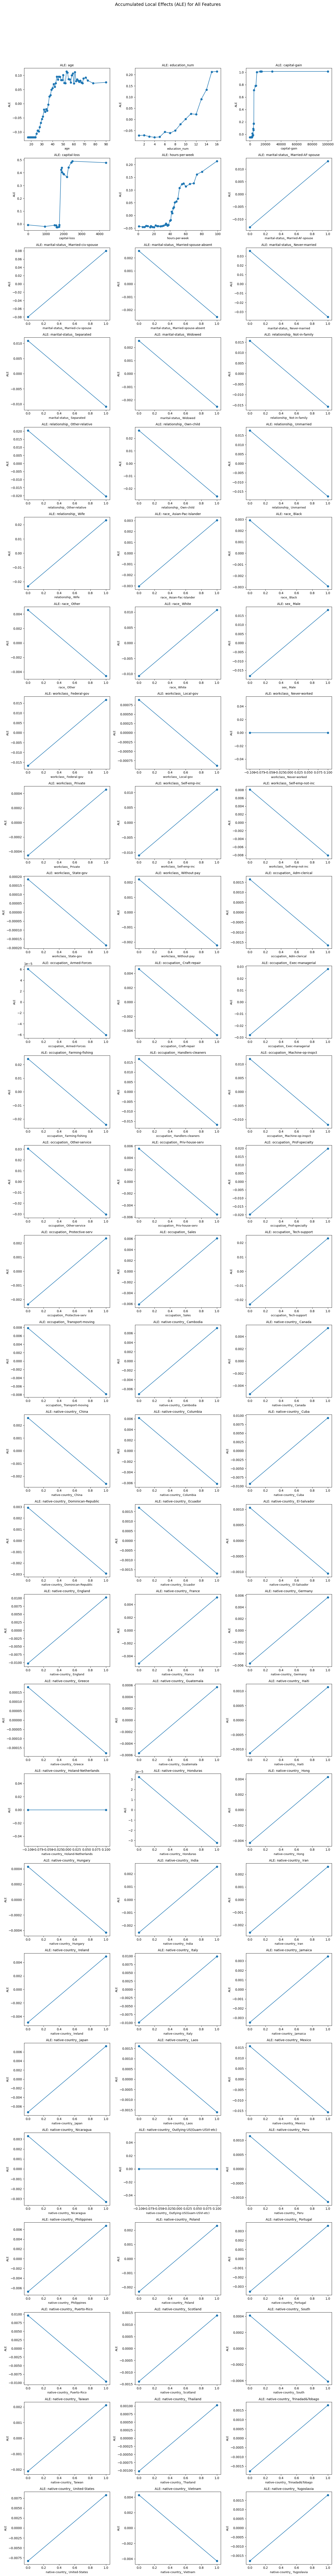

In [10]:
import matplotlib.pyplot as plt
import math

# Number of features to plot
num_features = len(feature_names)

# Define subplot grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_features / cols)

# Set figure size (adjust as needed)
plt.figure(figsize=(cols * 5, rows * 4))

for idx, fname in enumerate(feature_names):
    plt.subplot(rows, cols, idx + 1)
    plt.plot(explanation.feature_values[idx], explanation.ale_values[idx], marker='o')
    plt.xlabel(fname, fontsize=9)
    plt.ylabel("ALE", fontsize=9)
    plt.title(f"ALE: {fname}", fontsize=10)
    plt.tight_layout()

plt.suptitle("Accumulated Local Effects (ALE) for All Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Zautomatyzowana wizualizacja

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from alibi.explainers import ALE


class ALEVisualizer:
    def __init__(self, feature_names=None):
        self.feature_names = feature_names
        self.ale = None
        self.explanation = None

    def fit(self, predict_fn, feature_names=None):
        """
        Initialize the ALE explainer with a prediction function and optional feature names.
        """
        if feature_names:
            self.feature_names = feature_names
        self.ale = ALE(predictor=predict_fn, feature_names=self.feature_names)

    def explain(self, X):
        """
        Compute ALE explanation for the input dataset X.
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        self.explanation = self.ale.explain(X)

    def plot(self, feature_names_to_plot, model_name="", cols=3):
        """
        Plot ALE curves for exactly 6 specified features in a 3x2 grid.
        
        Parameters:
        - feature_names_to_plot: list of 6 feature names to plot.
        - model_name: name of the model (optional), used in the plot title.
        - cols: number of columns in the subplot grid (default = 3).
        """
        if self.explanation is None:
            raise ValueError("You must call explain(X) before plotting.")

        feature_names = self.feature_names
        ale_values = self.explanation.ale_values
        feature_values = self.explanation.feature_values

        # Get indices for requested features
        selected_indices = [feature_names.index(f) for f in feature_names_to_plot]
        rows = math.ceil(len(selected_indices) / cols)

        plt.figure(figsize=(cols * 5, rows * 4))

        for i, idx in enumerate(selected_indices):
            fname = feature_names[idx]
            plt.subplot(rows, cols, i + 1)
            plt.plot(feature_values[idx], ale_values[idx], marker='o')
            plt.xlabel(fname, fontsize=9)
            plt.ylabel("ALE", fontsize=9)
            plt.title(f"ALE: {fname}", fontsize=10)
            plt.tight_layout()

        plt.suptitle(f"Accumulated Local Effects (ALE) for {model_name}", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

Chcemy wizualizację dla metod GaussianNB, RF, GradientBoosting, SVC, MLP, KNN. Dla cech age, capital-loss, capital-gain, education_num, fnlwgt i hours-per-week.

In [12]:
feature_names_selected = ['age', 'capital-loss', 'capital-gain', 'education_num', 'hours-per-week']

In [13]:
from typing import List
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from pandas.io.formats import style
from tqdm import tqdm

RANDOM_STATE = 42

models : List[BaseEstimator] = [
    GaussianNB(),
    RandomForestClassifier(random_state=RANDOM_STATE),
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    SVC(random_state=RANDOM_STATE),
    MLPClassifier(random_state=RANDOM_STATE),
    KNeighborsClassifier(),
]

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2

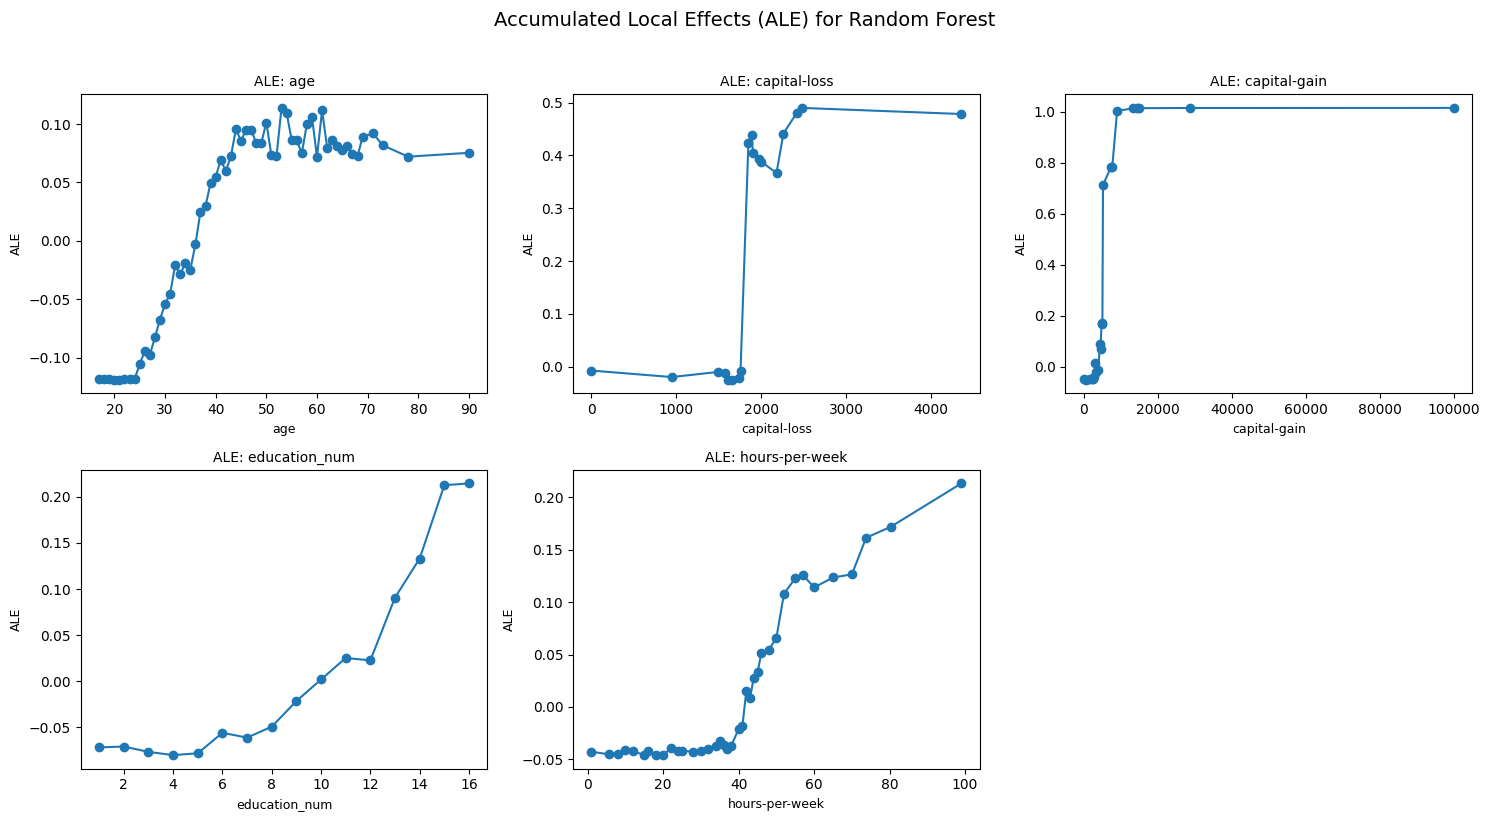

In [14]:


ale_vis = ALEVisualizer(feature_names = feature_names)
ale_vis.fit(predict_fn = predict_fn)
ale_vis.explain(X_test)

ale_vis.plot(
    feature_names_to_plot = feature_names_selected,
    model_name="Random Forest"
)

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation

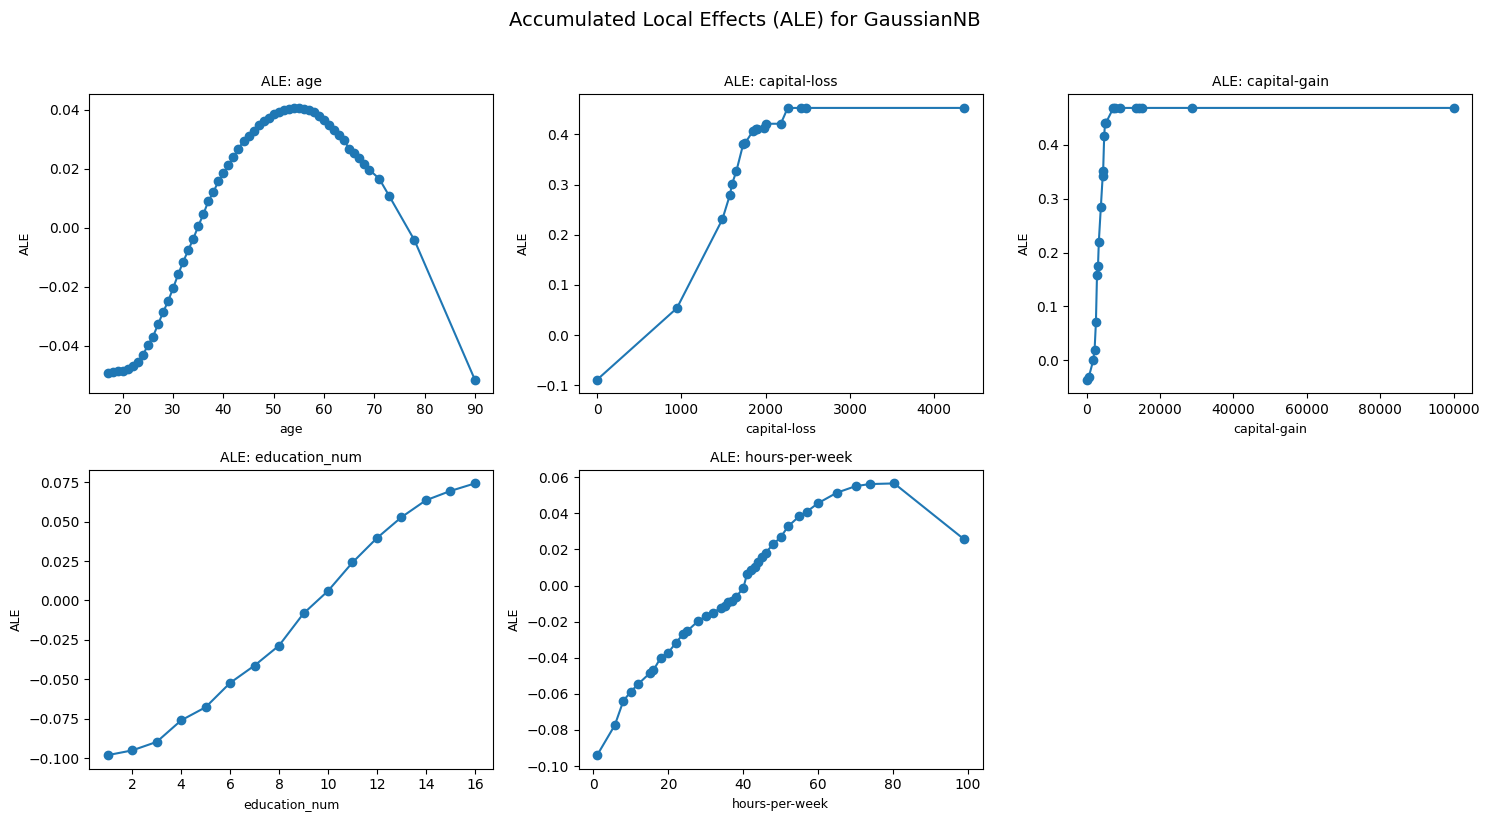

In [15]:
model = GaussianNB()
model.fit(X_train, y_train)
def predict_fn(X):
            if hasattr(model, "predict_proba"):
                return model.predict_proba(X)[:, 1]
            else:
                return model.decision_function(X)
ale_vis = ALEVisualizer(feature_names = feature_names)
ale_vis.fit(predict_fn = predict_fn)
ale_vis.explain(X_test)

ale_vis.plot(
    feature_names_to_plot = feature_names_selected,
    model_name = "GaussianNB"
)

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  

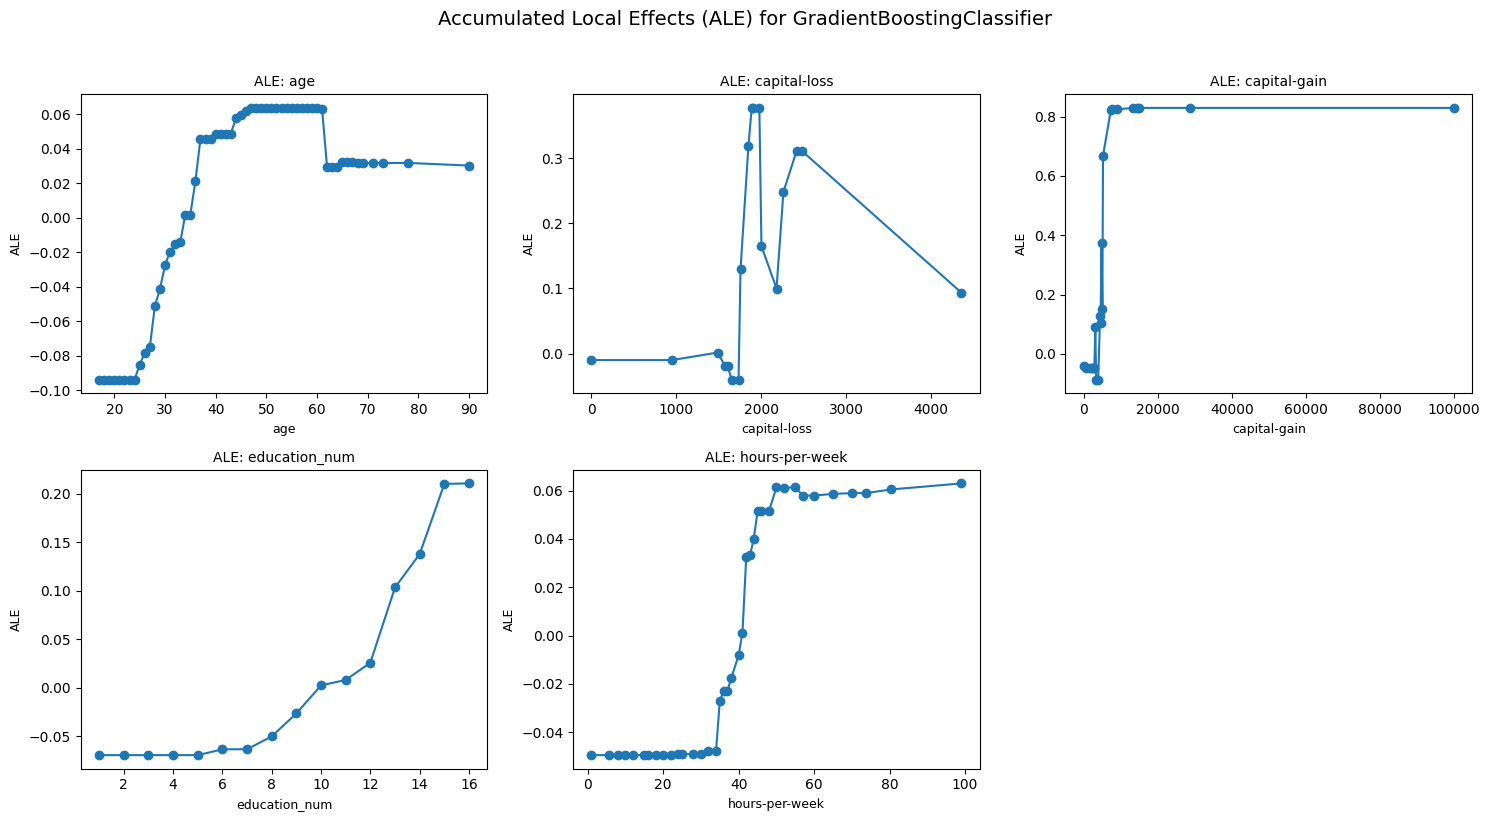

In [16]:
model = GradientBoostingClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
def predict_fn(X):
            if hasattr(model, "predict_proba"):
                return model.predict_proba(X)[:, 1]
            else:
                return model.decision_function(X)
ale_vis = ALEVisualizer(feature_names = feature_names)
ale_vis.fit(predict_fn = predict_fn)
ale_vis.explain(X_test)

ale_vis.plot(
    feature_names_to_plot = feature_names_selected,
    model_name = "GradientBoostingClassifier"
)

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-x

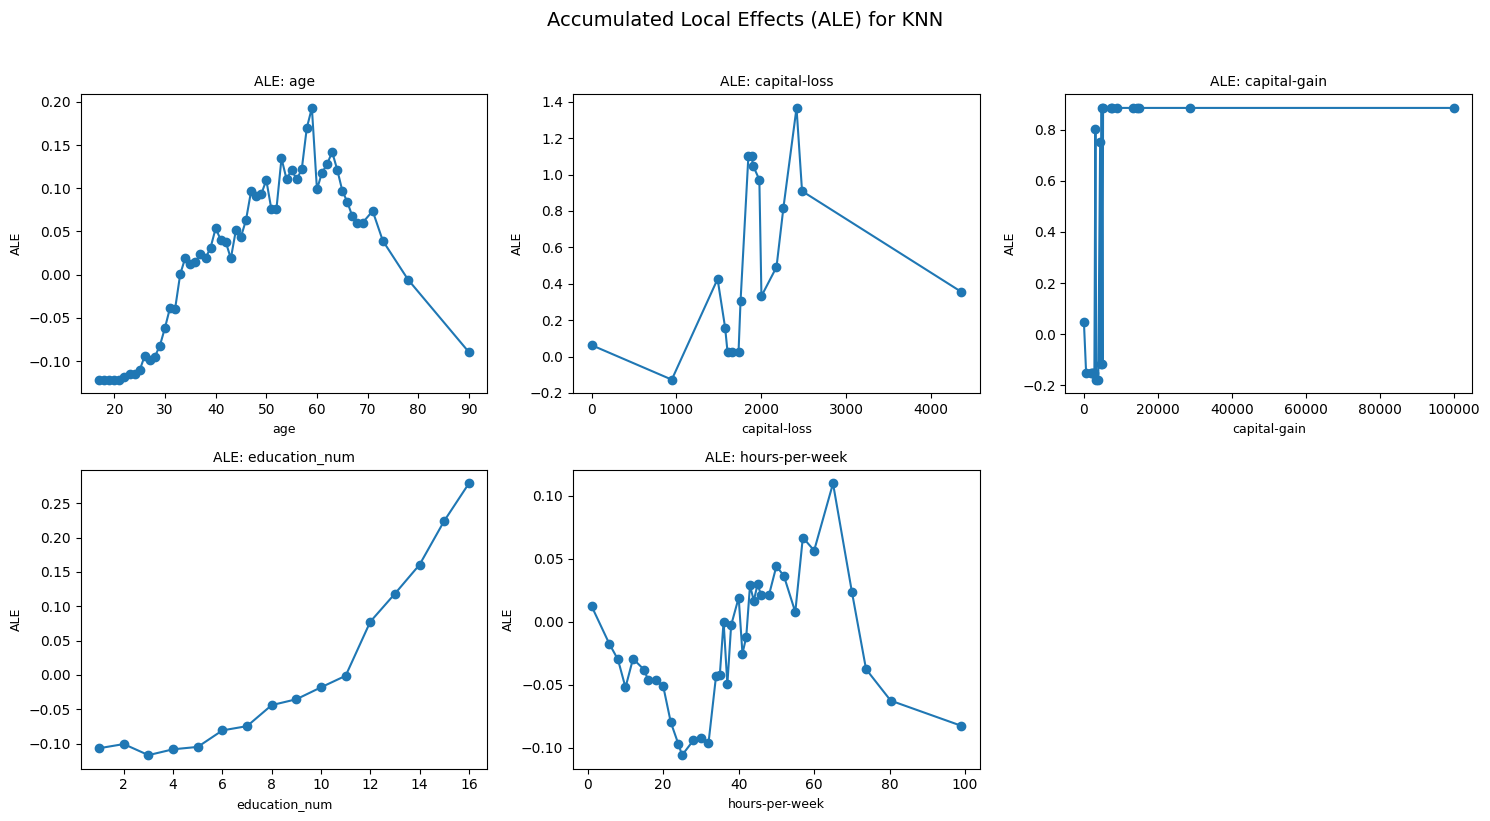

In [17]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
def predict_fn(X):
            if hasattr(model, "predict_proba"):
                return model.predict_proba(X)[:, 1]
            else:
                return model.decision_function(X)
ale_vis = ALEVisualizer(feature_names = feature_names)
ale_vis.fit(predict_fn = predict_fn)
ale_vis.explain(X_test)

ale_vis.plot(
    feature_names_to_plot = feature_names_selected,
    model_name = "KNN"
)

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-

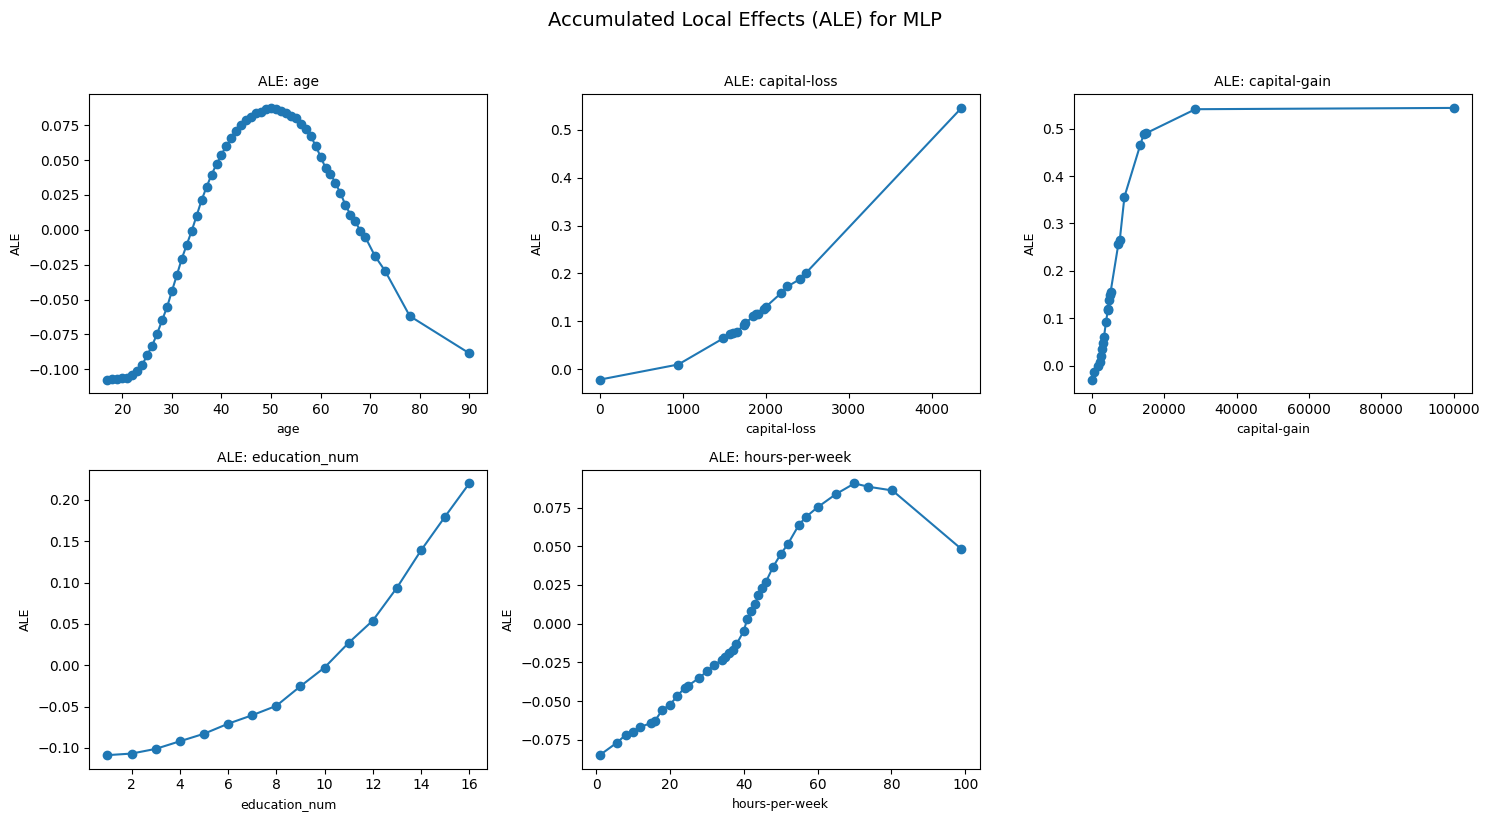

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

RANDOM_STATE = 42

model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('MLP', MLPClassifier(random_state=RANDOM_STATE, max_iter=300))
])
model.fit(X_train, y_train)
def predict_fn(X):
            if hasattr(model, "predict_proba"):
                return model.predict_proba(X)[:, 1]
            else:
                return model.decision_function(X)
ale_vis = ALEVisualizer(feature_names = feature_names)
ale_vis.fit(predict_fn = predict_fn)
ale_vis.explain(X_test)

ale_vis.plot(
    feature_names_to_plot = feature_names_selected,
    model_name = "MLP"
)

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not h

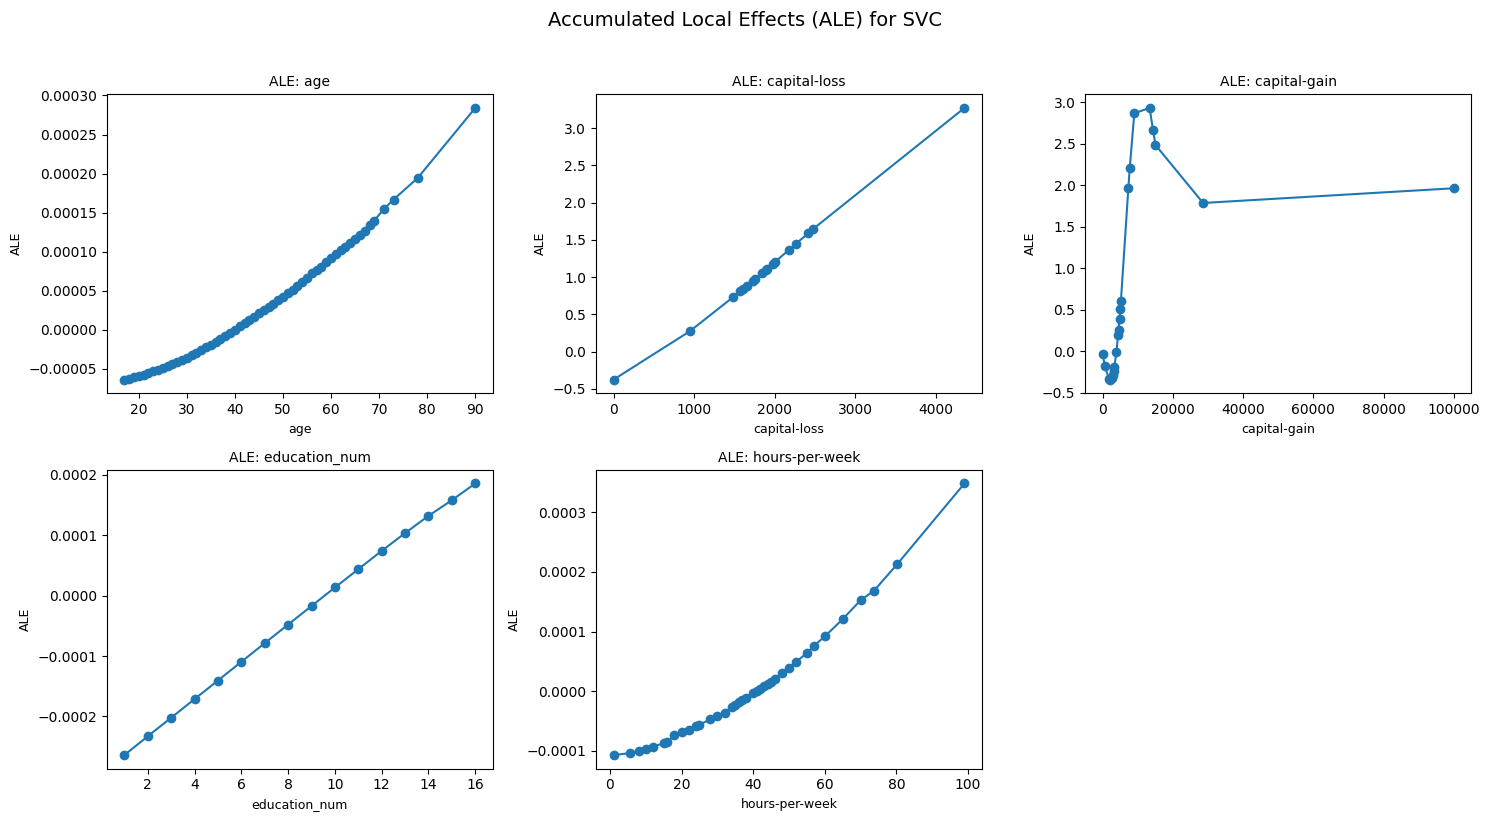

In [19]:
model = SVC()
model.fit(X_train, y_train)
def predict_fn(X):
            if hasattr(model, "predict_proba"):
                return model.predict_proba(X)[:, 1]
            else:
                return model.decision_function(X)
ale_vis = ALEVisualizer(feature_names = feature_names)
ale_vis.fit(predict_fn = predict_fn)
ale_vis.explain(X_test)

ale_vis.plot(
    feature_names_to_plot = feature_names_selected,
    model_name = "SVC"
)

In [32]:
import scienceplots

plt.style.use(['science', 'ieee'])

def plot_ale_for_feature_across_models(
    predict_fns,
    model_names,
    X,
    feature_name,
    feature_names,
    cols=2
):
    """
    Plot ALE curves for a single feature across multiple models.

    Parameters:
    - predict_fns: list of prediction functions (e.g., lambda X: model.predict_proba(X)[:, 1])
    - model_names: list of model names (for subplot titles)
    - X: data (Pandas DataFrame or NumPy array)
    - feature_name: the feature to explain
    - feature_names: list of all feature names (must include feature_name)
    - cols: number of columns in the subplot grid (default=3)
    """
    if feature_name not in feature_names:
        raise ValueError(f"Feature '{feature_name}' not found in feature_names.")

    if len(predict_fns) != len(model_names):
        raise ValueError("predict_fns and model_names must have the same length.")

    feature_idx = feature_names.index(feature_name)
    n_models = len(predict_fns)
    rows = math.ceil(n_models / cols)

    _, axes = plt.subplots(ncols=2, nrows=rows, figsize=(6, 8), constrained_layout=True)
    axes = axes.flatten()

    for i, (predict_fn, name) in enumerate(zip(predict_fns, model_names)):
        ale = ALE(predictor=predict_fn, feature_names=feature_names)
        explanation = ale.explain(X.to_numpy() if isinstance(X, pd.DataFrame) else X)

        values = explanation.feature_values[feature_idx]
        effects = explanation.ale_values[feature_idx]

        ax = axes[i]
        ax.plot(values, effects, marker='o', markersize=3, linewidth=1)
        ax.set_xlabel(feature_name, fontsize=9)
        ax.set_ylabel("ALE", fontsize=9)
        ax.set_title(name, fontsize=10)

    plt.tight_layout()
    plt.savefig(f'../plots/ale_{feature_name}.pdf')
    plt.show()

In [33]:
def get_predict_fns_from_models(models):
    predict_fns = []

    for model in models:
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            predict_fns.append(lambda X, m=model: m.predict_proba(X)[:, 1])
        elif hasattr(model, "decision_function"):
            predict_fns.append(lambda X, m=model: m.decision_function(X))
        elif hasattr(model, "predict"):
            predict_fns.append(lambda X, m=model: m.predict(X))
        else:
            raise ValueError(f"Model {model} does not support predict_proba, decision_function, or predict.")

    return predict_fns

In [34]:
models = [RandomForestClassifier(random_state=RANDOM_STATE), GaussianNB(), GradientBoostingClassifier(random_state=RANDOM_STATE), KNeighborsClassifier(), 
         Pipeline([('scaler', MinMaxScaler()), ('MLP', MLPClassifier(random_state=RANDOM_STATE, max_iter=300))]), SVC(kernel='rbf', max_iter=300), ]
predict_fns = get_predict_fns_from_models(models)

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [35]:
model_names=["Random Forest", "GaussianNB", "Gradient Boosting", "KNN", "MLP", "SVC"]
features = ['age', 'education_num', 'capital-gain', 'hours-per-week', 'capital-loss']

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MI

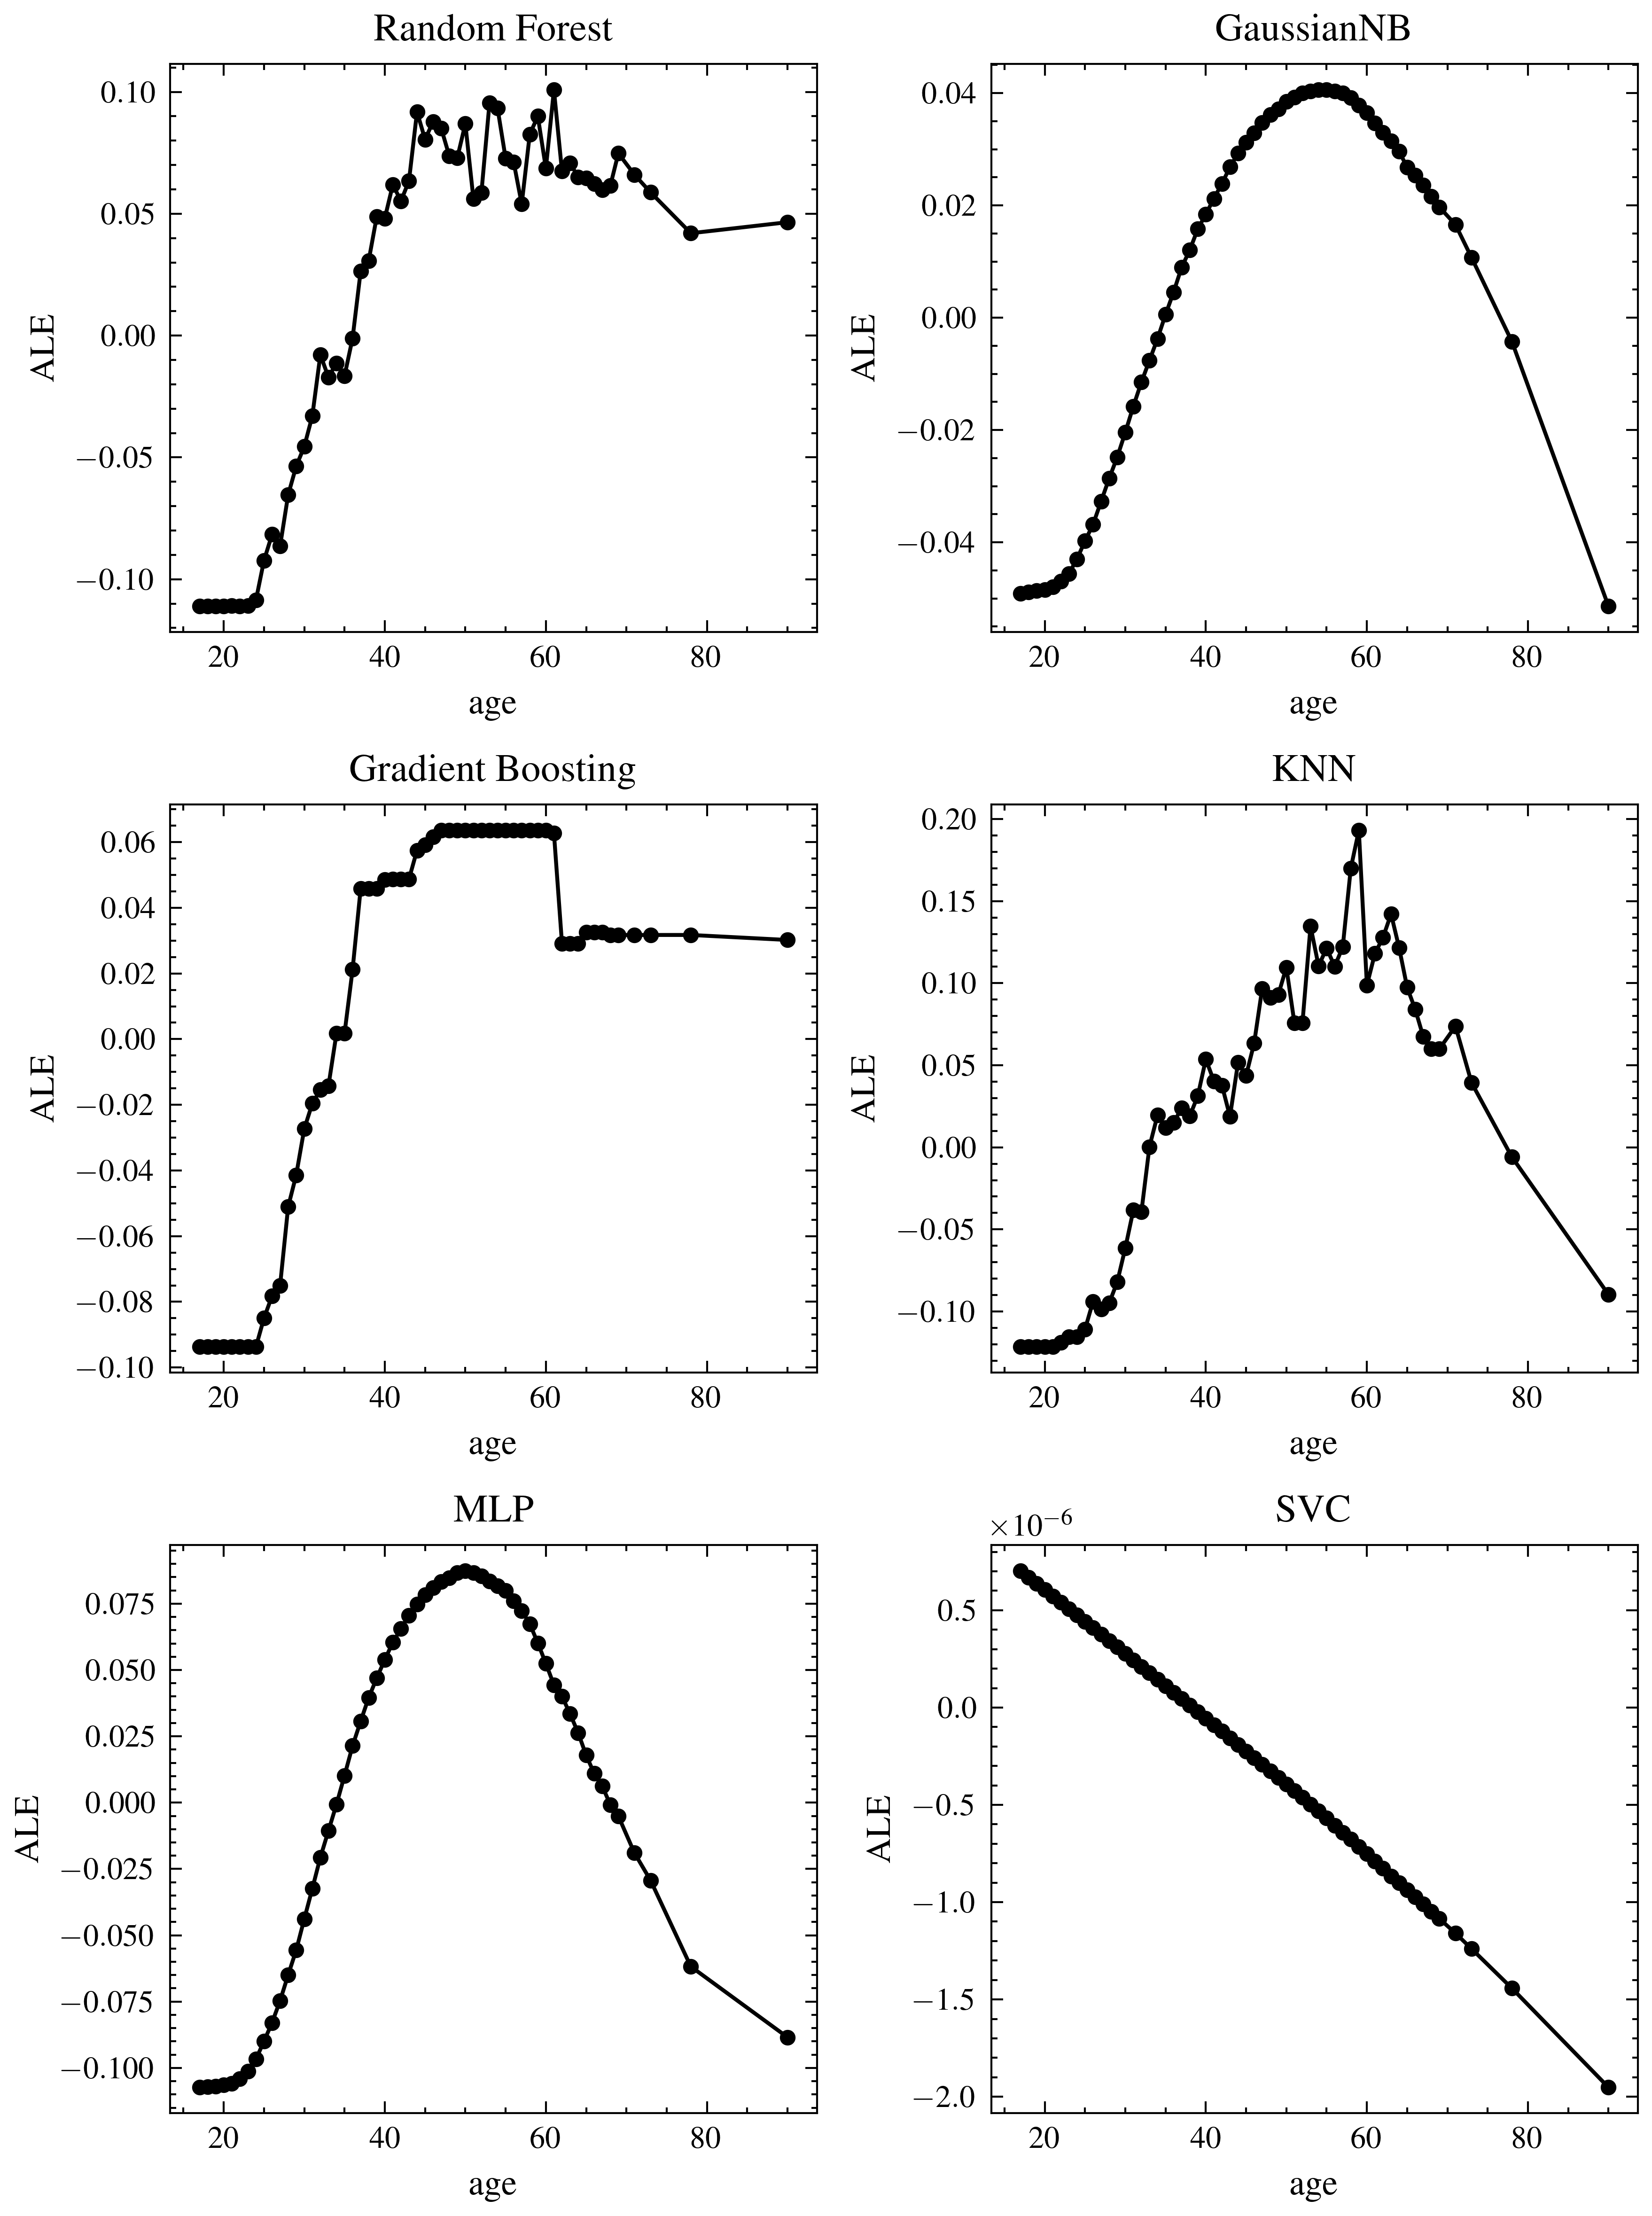

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MI

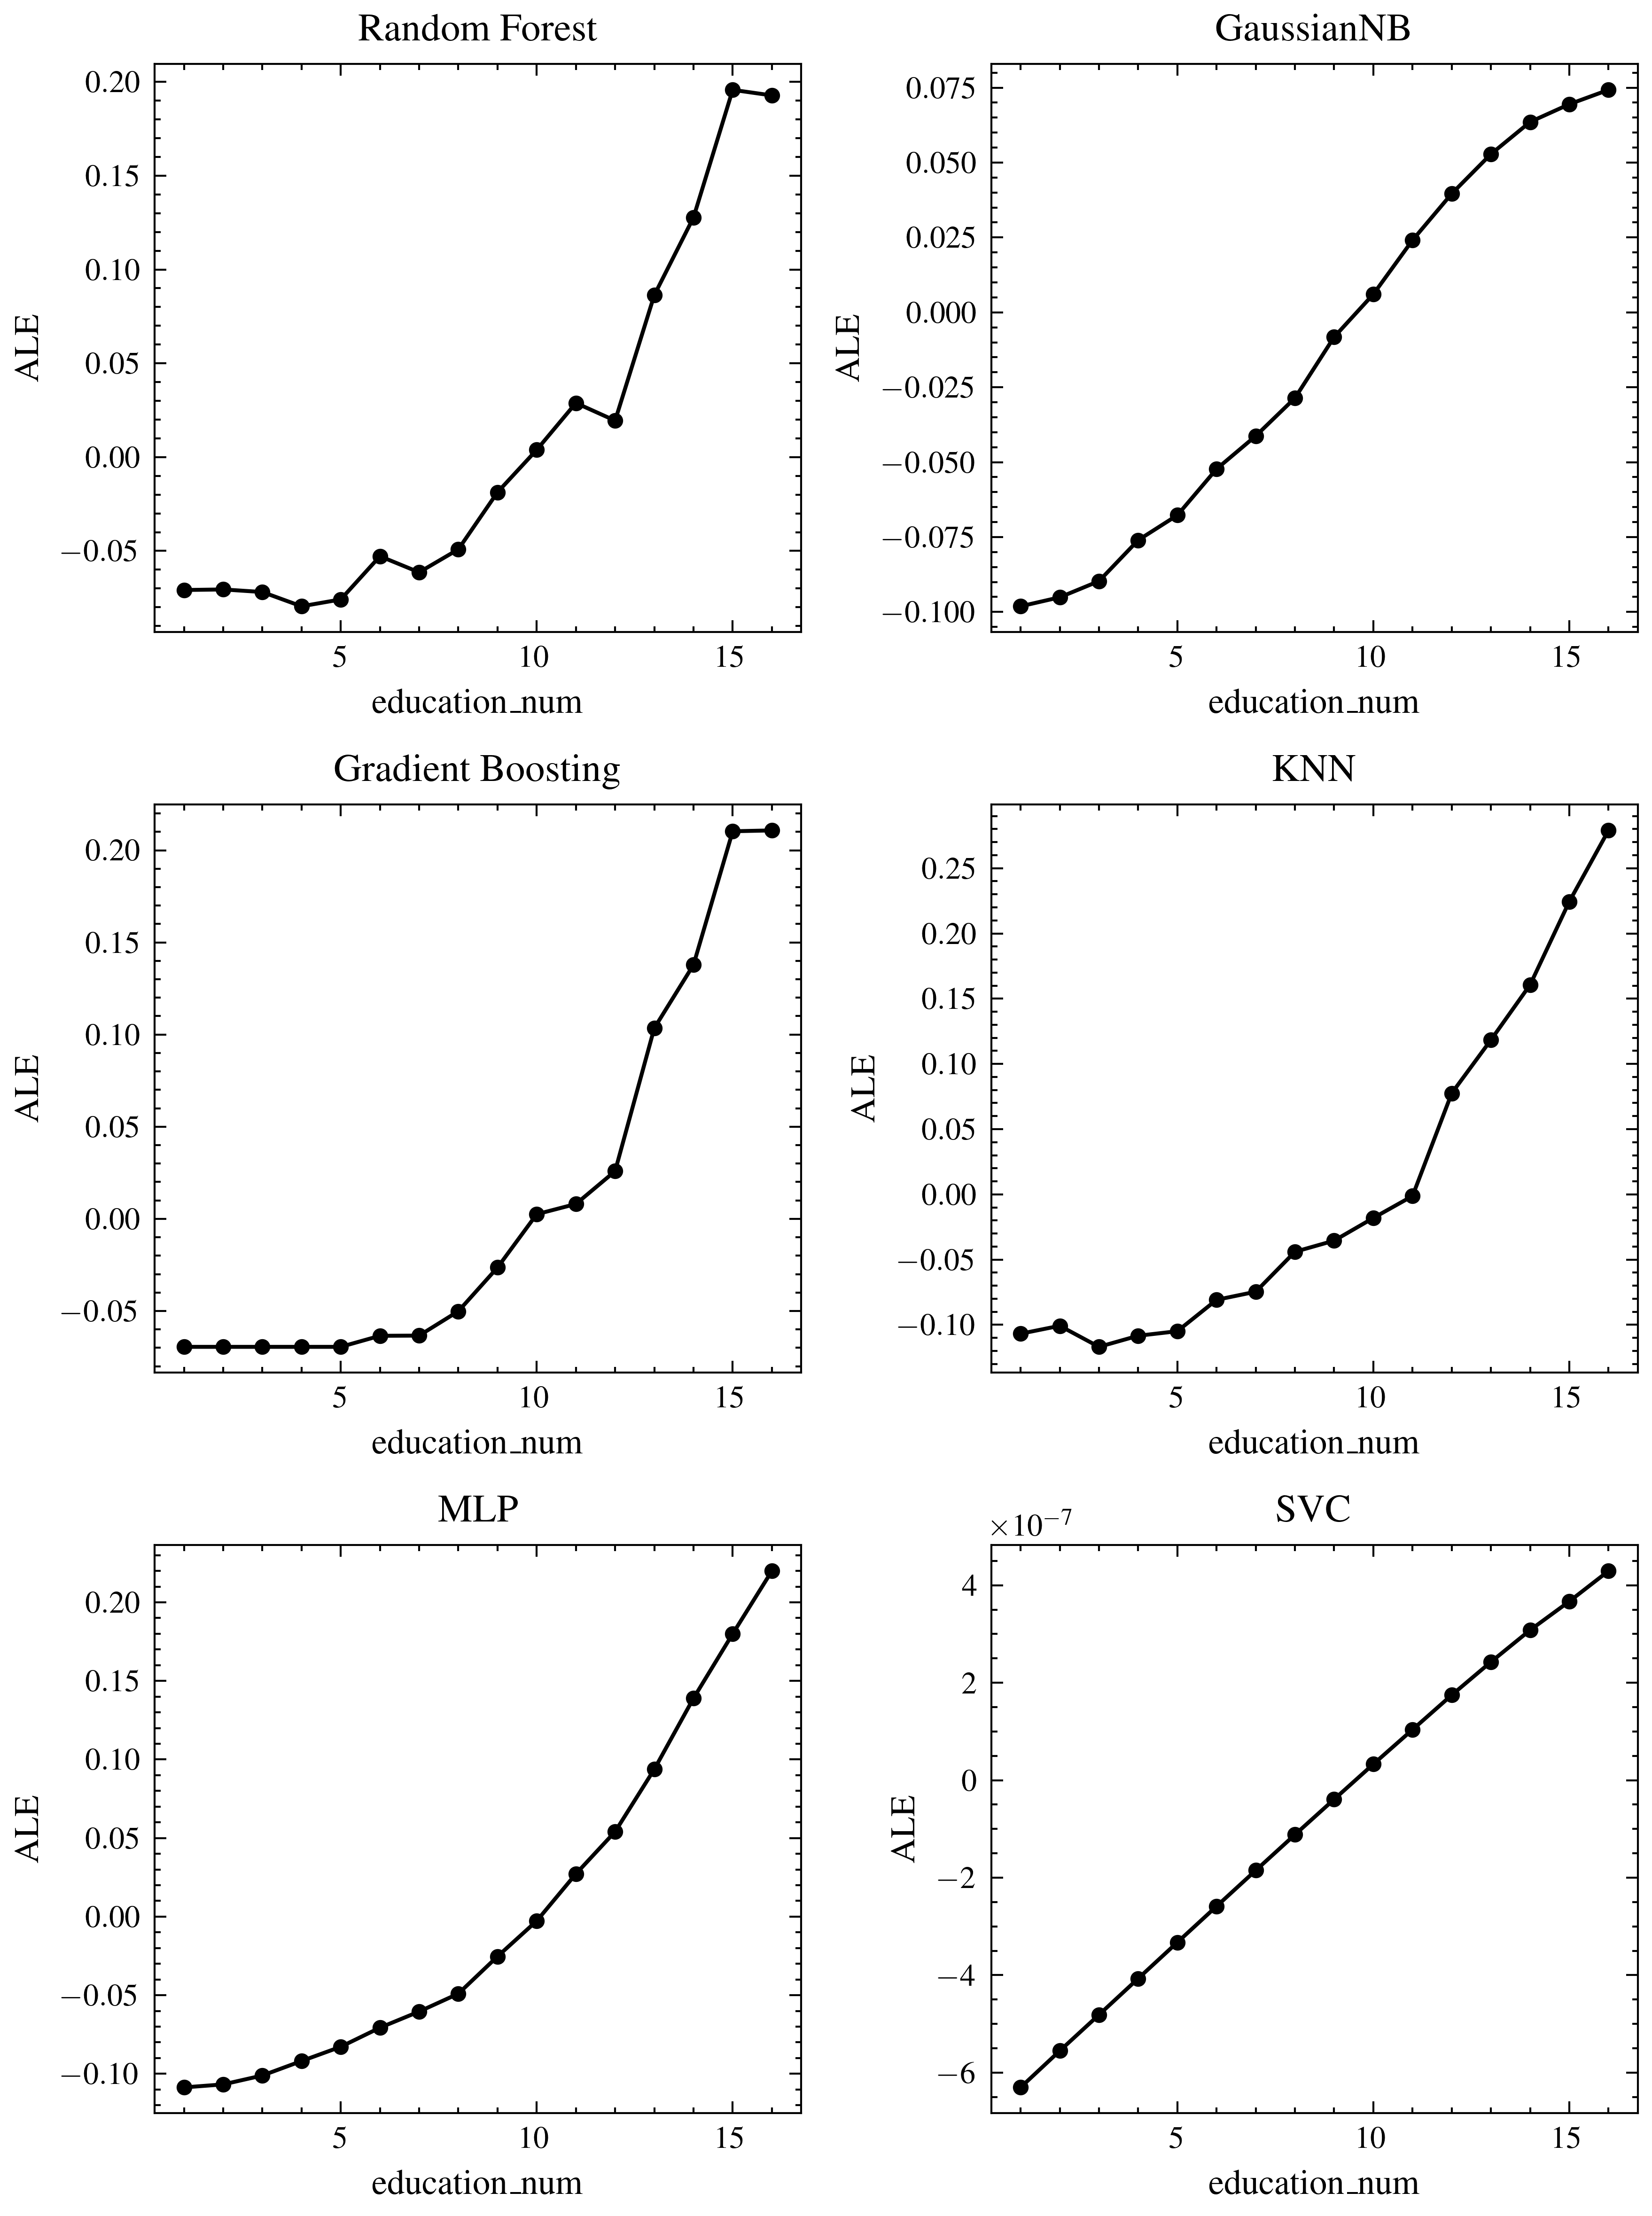

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MI

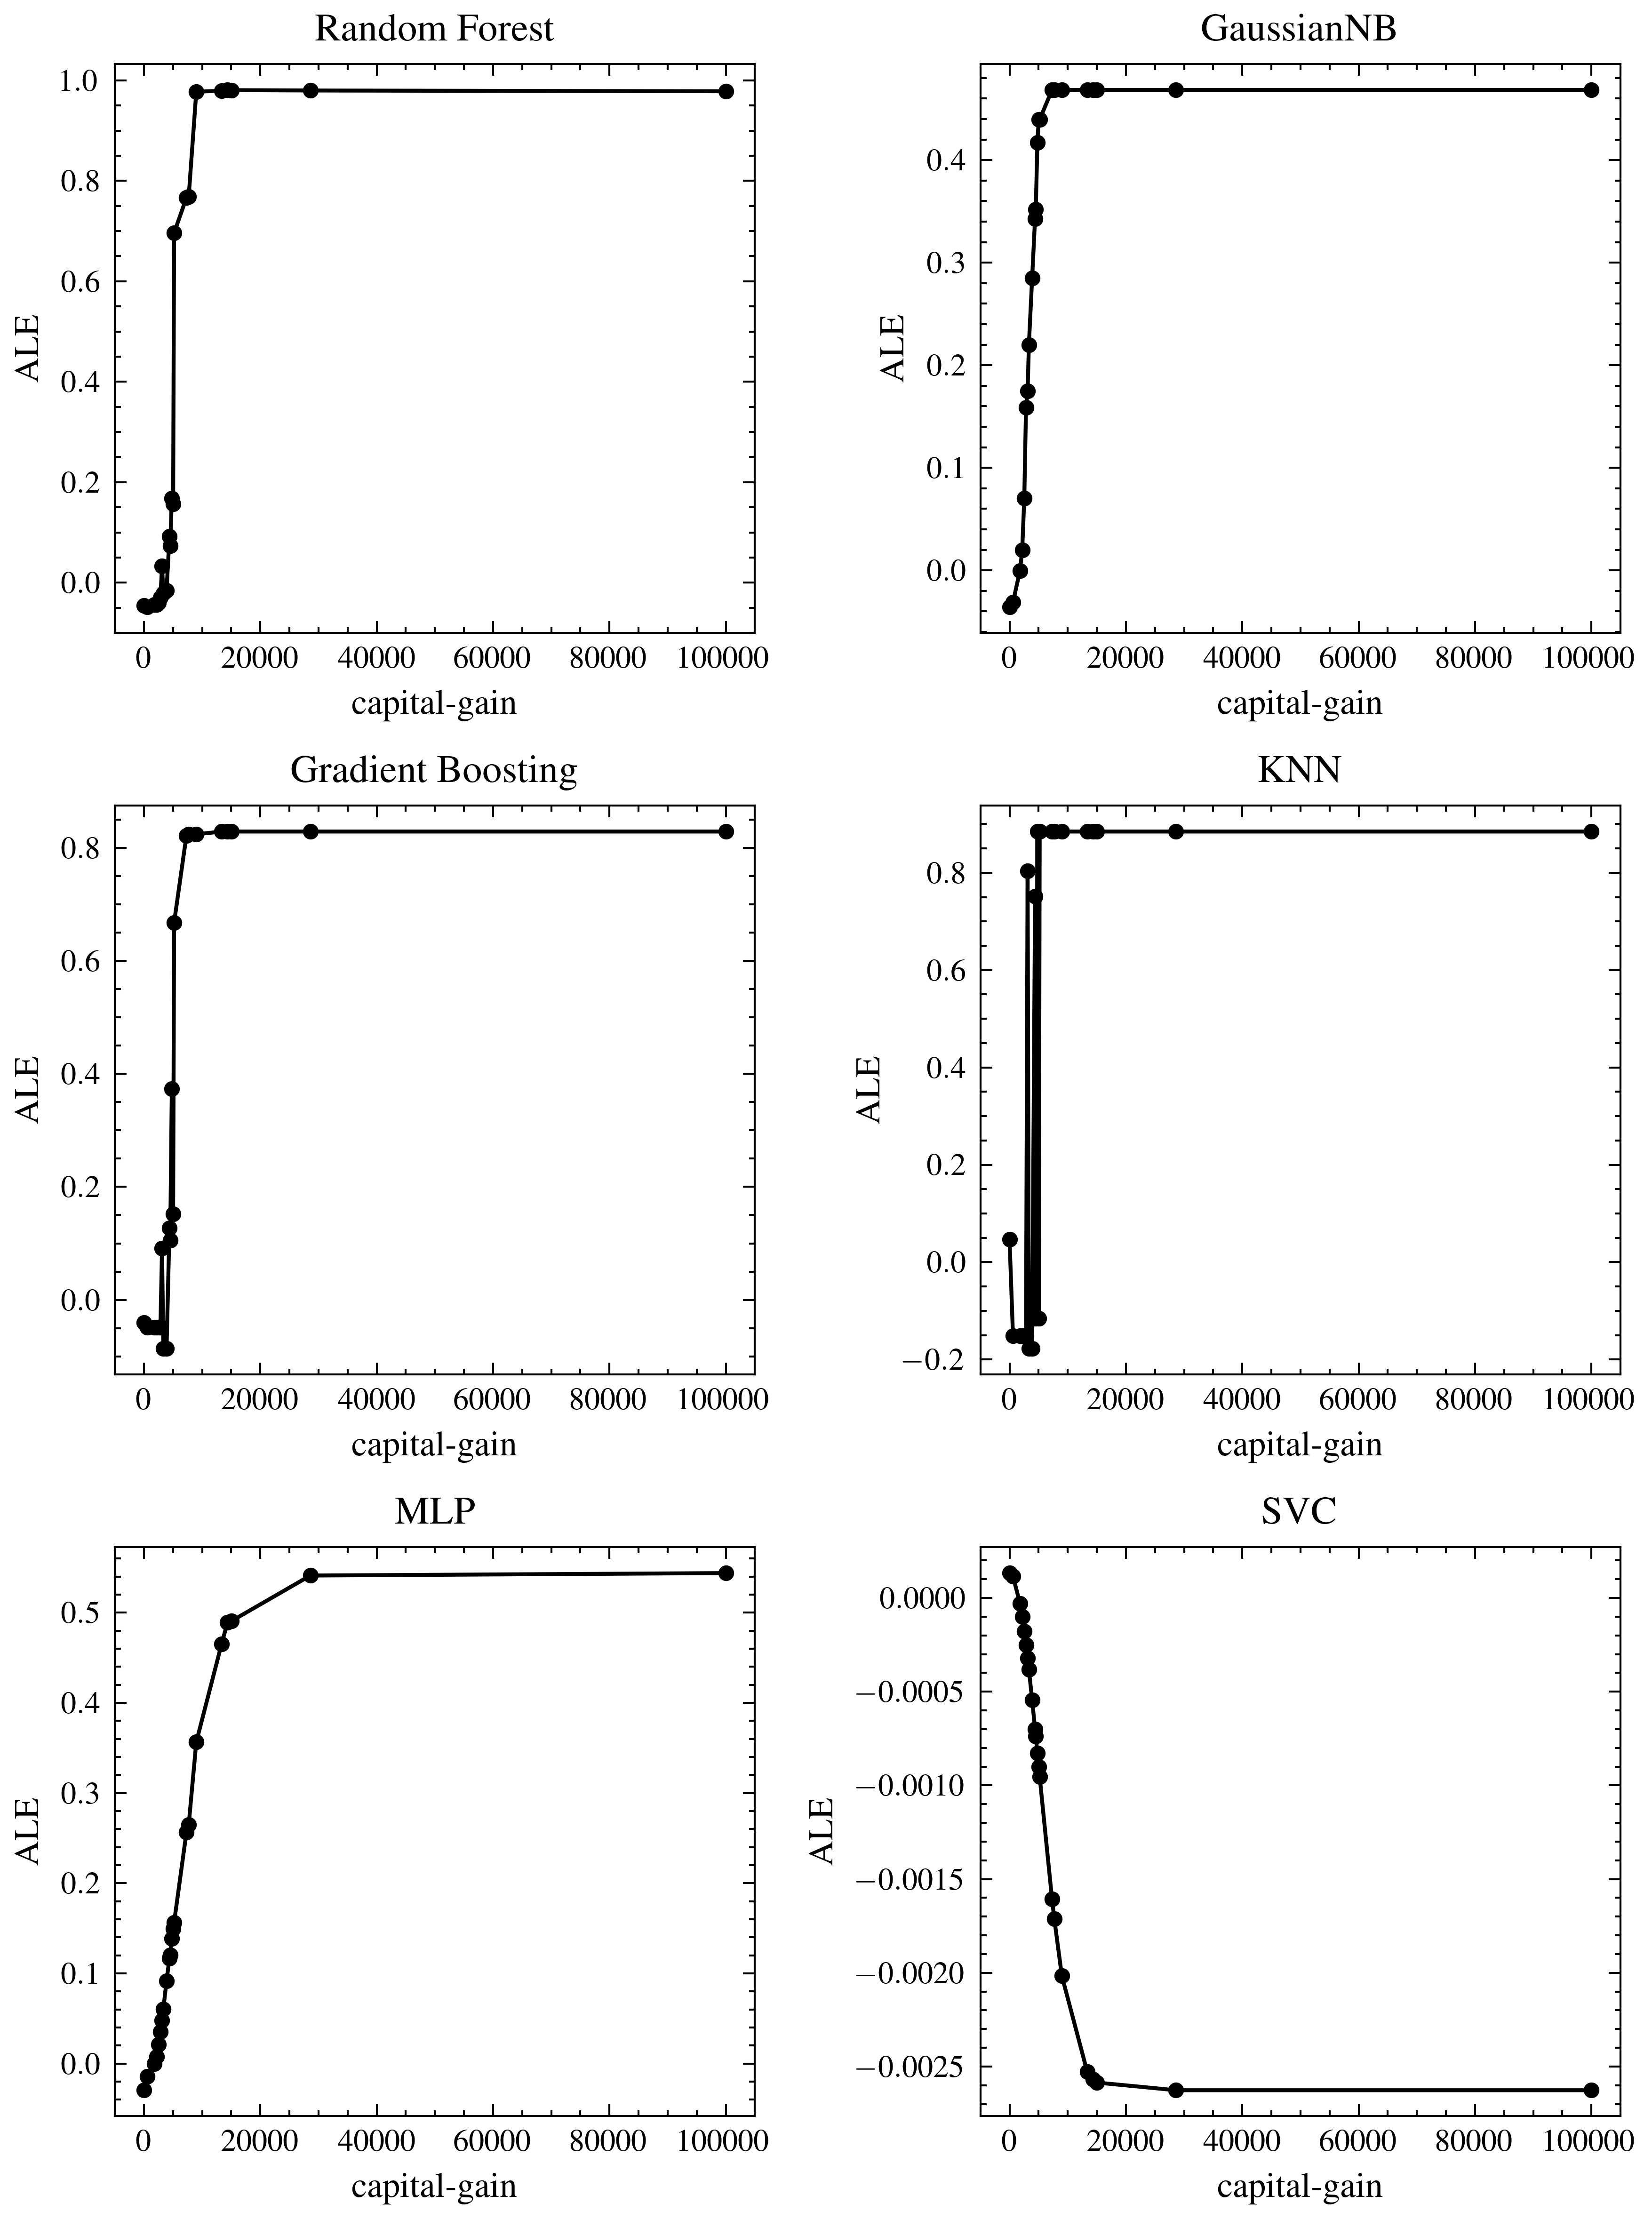

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MI

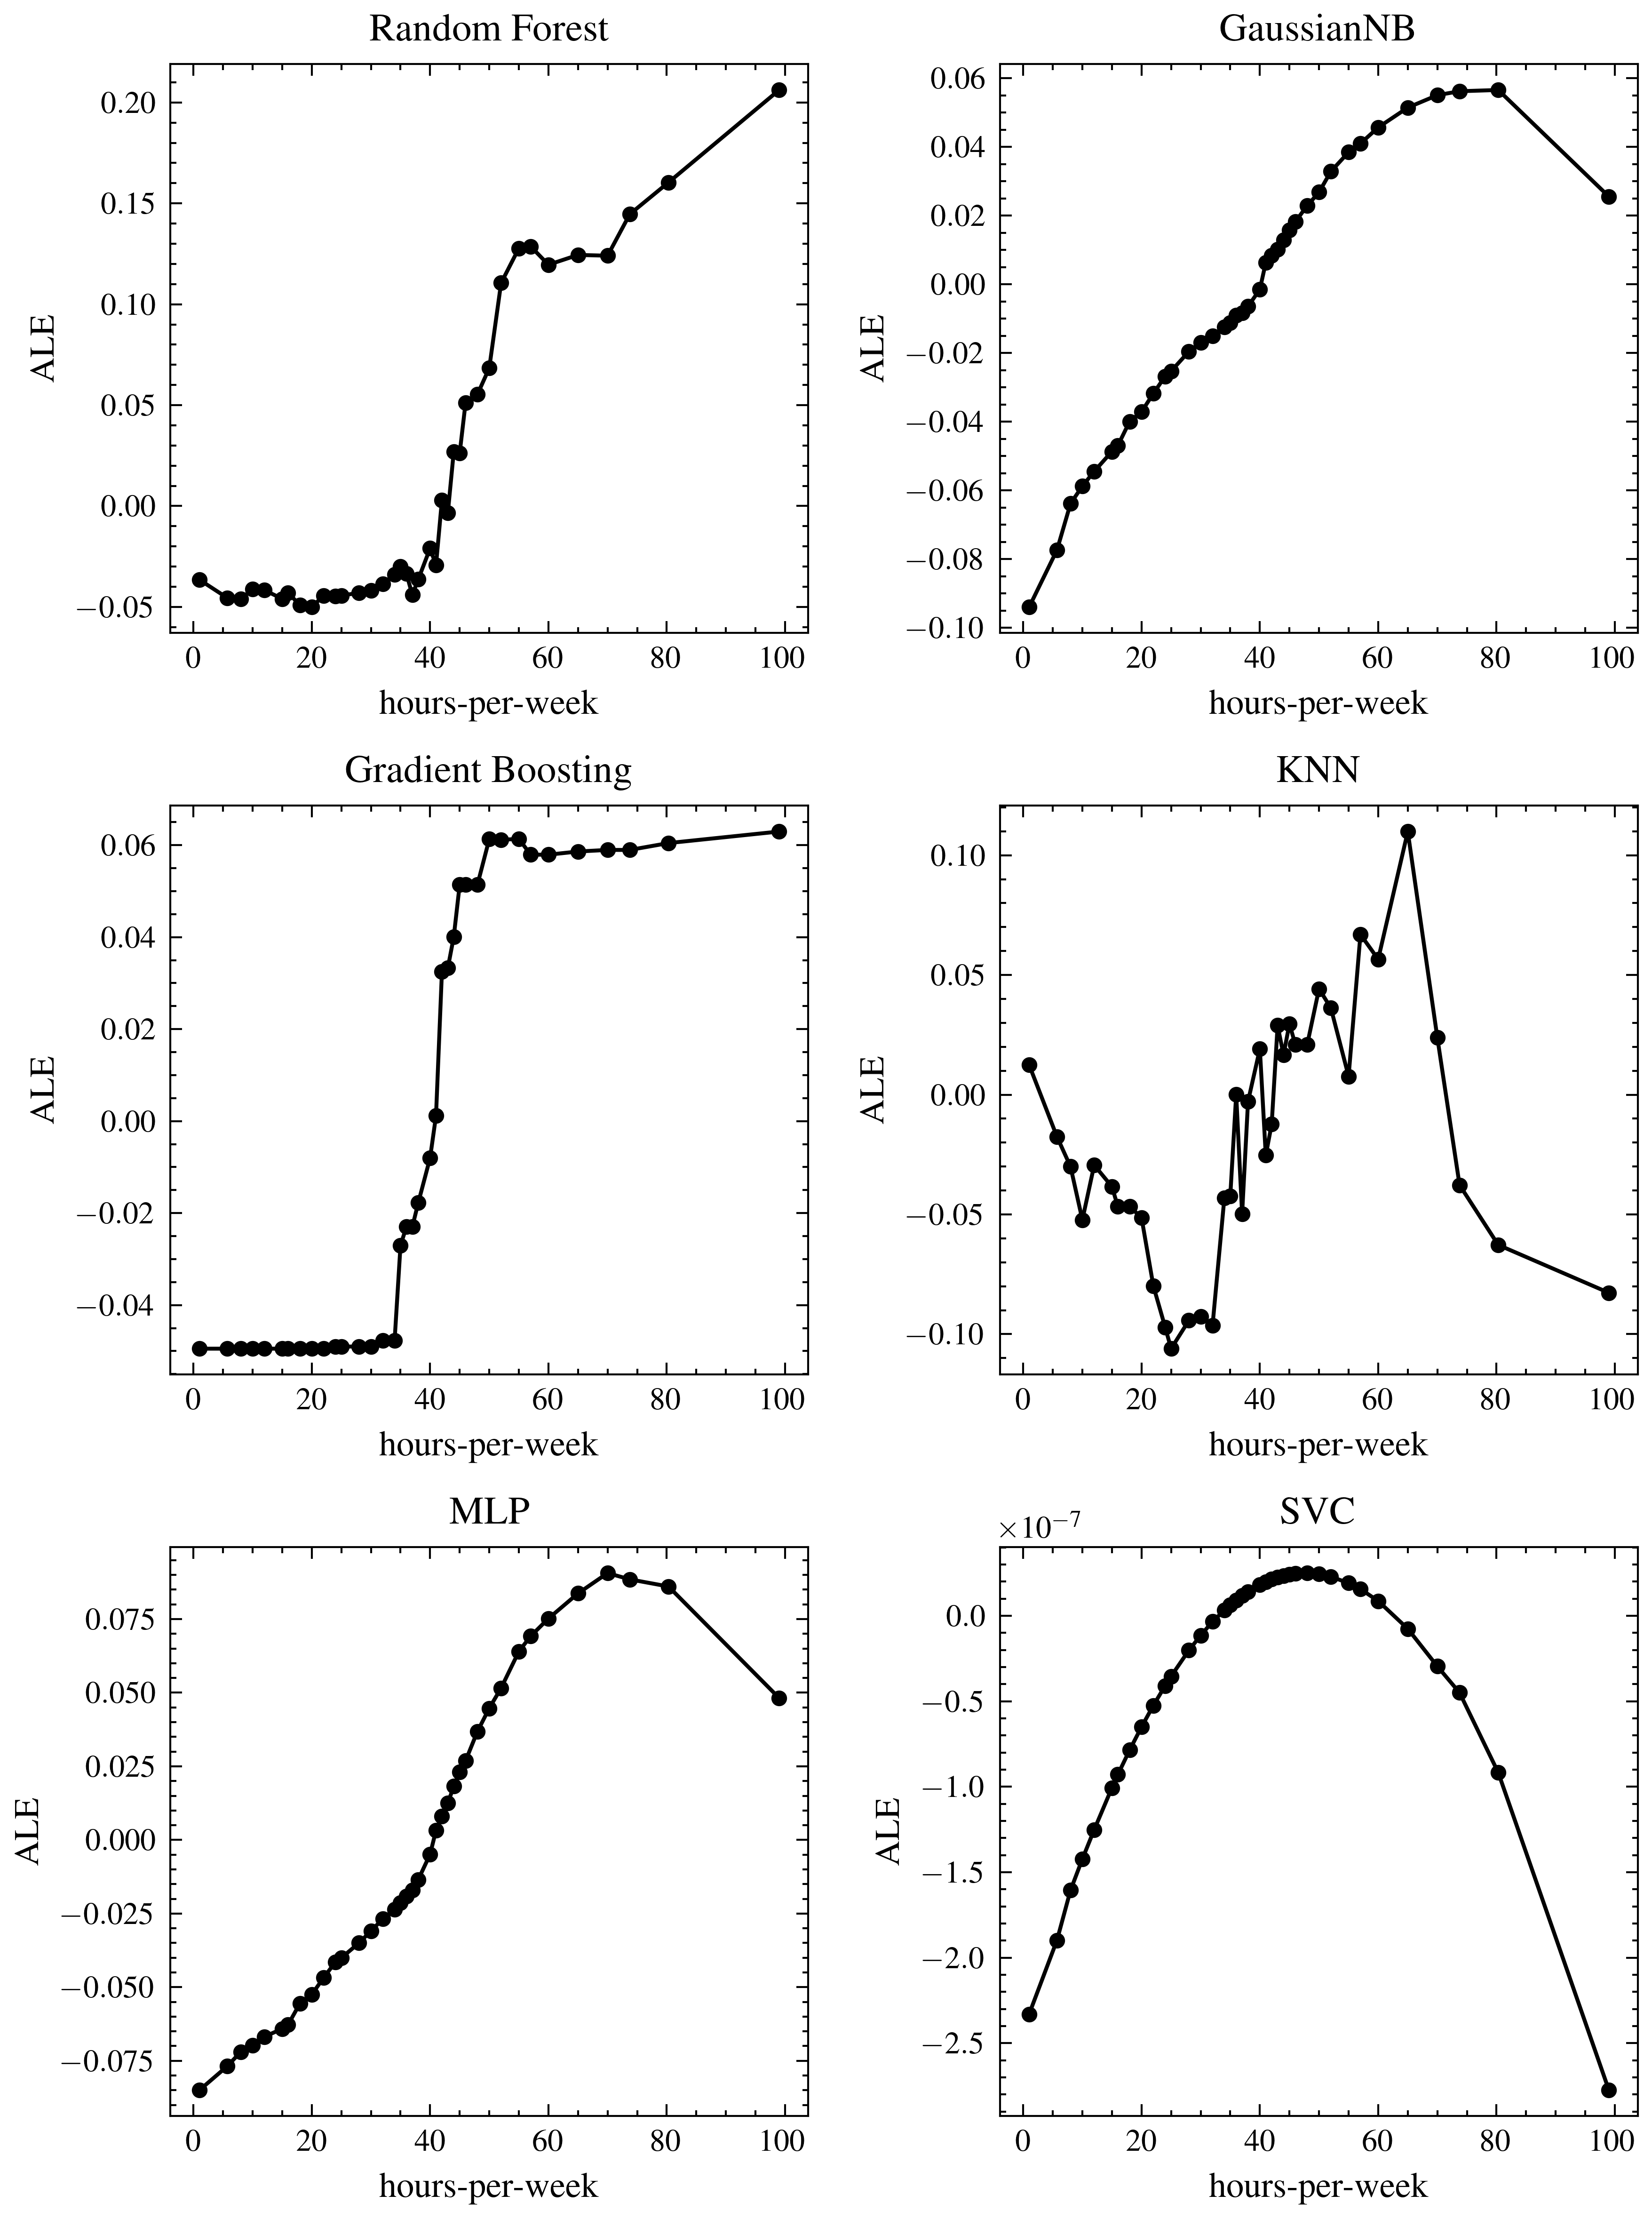

p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MINI9\zmum-xai\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
p:\MI

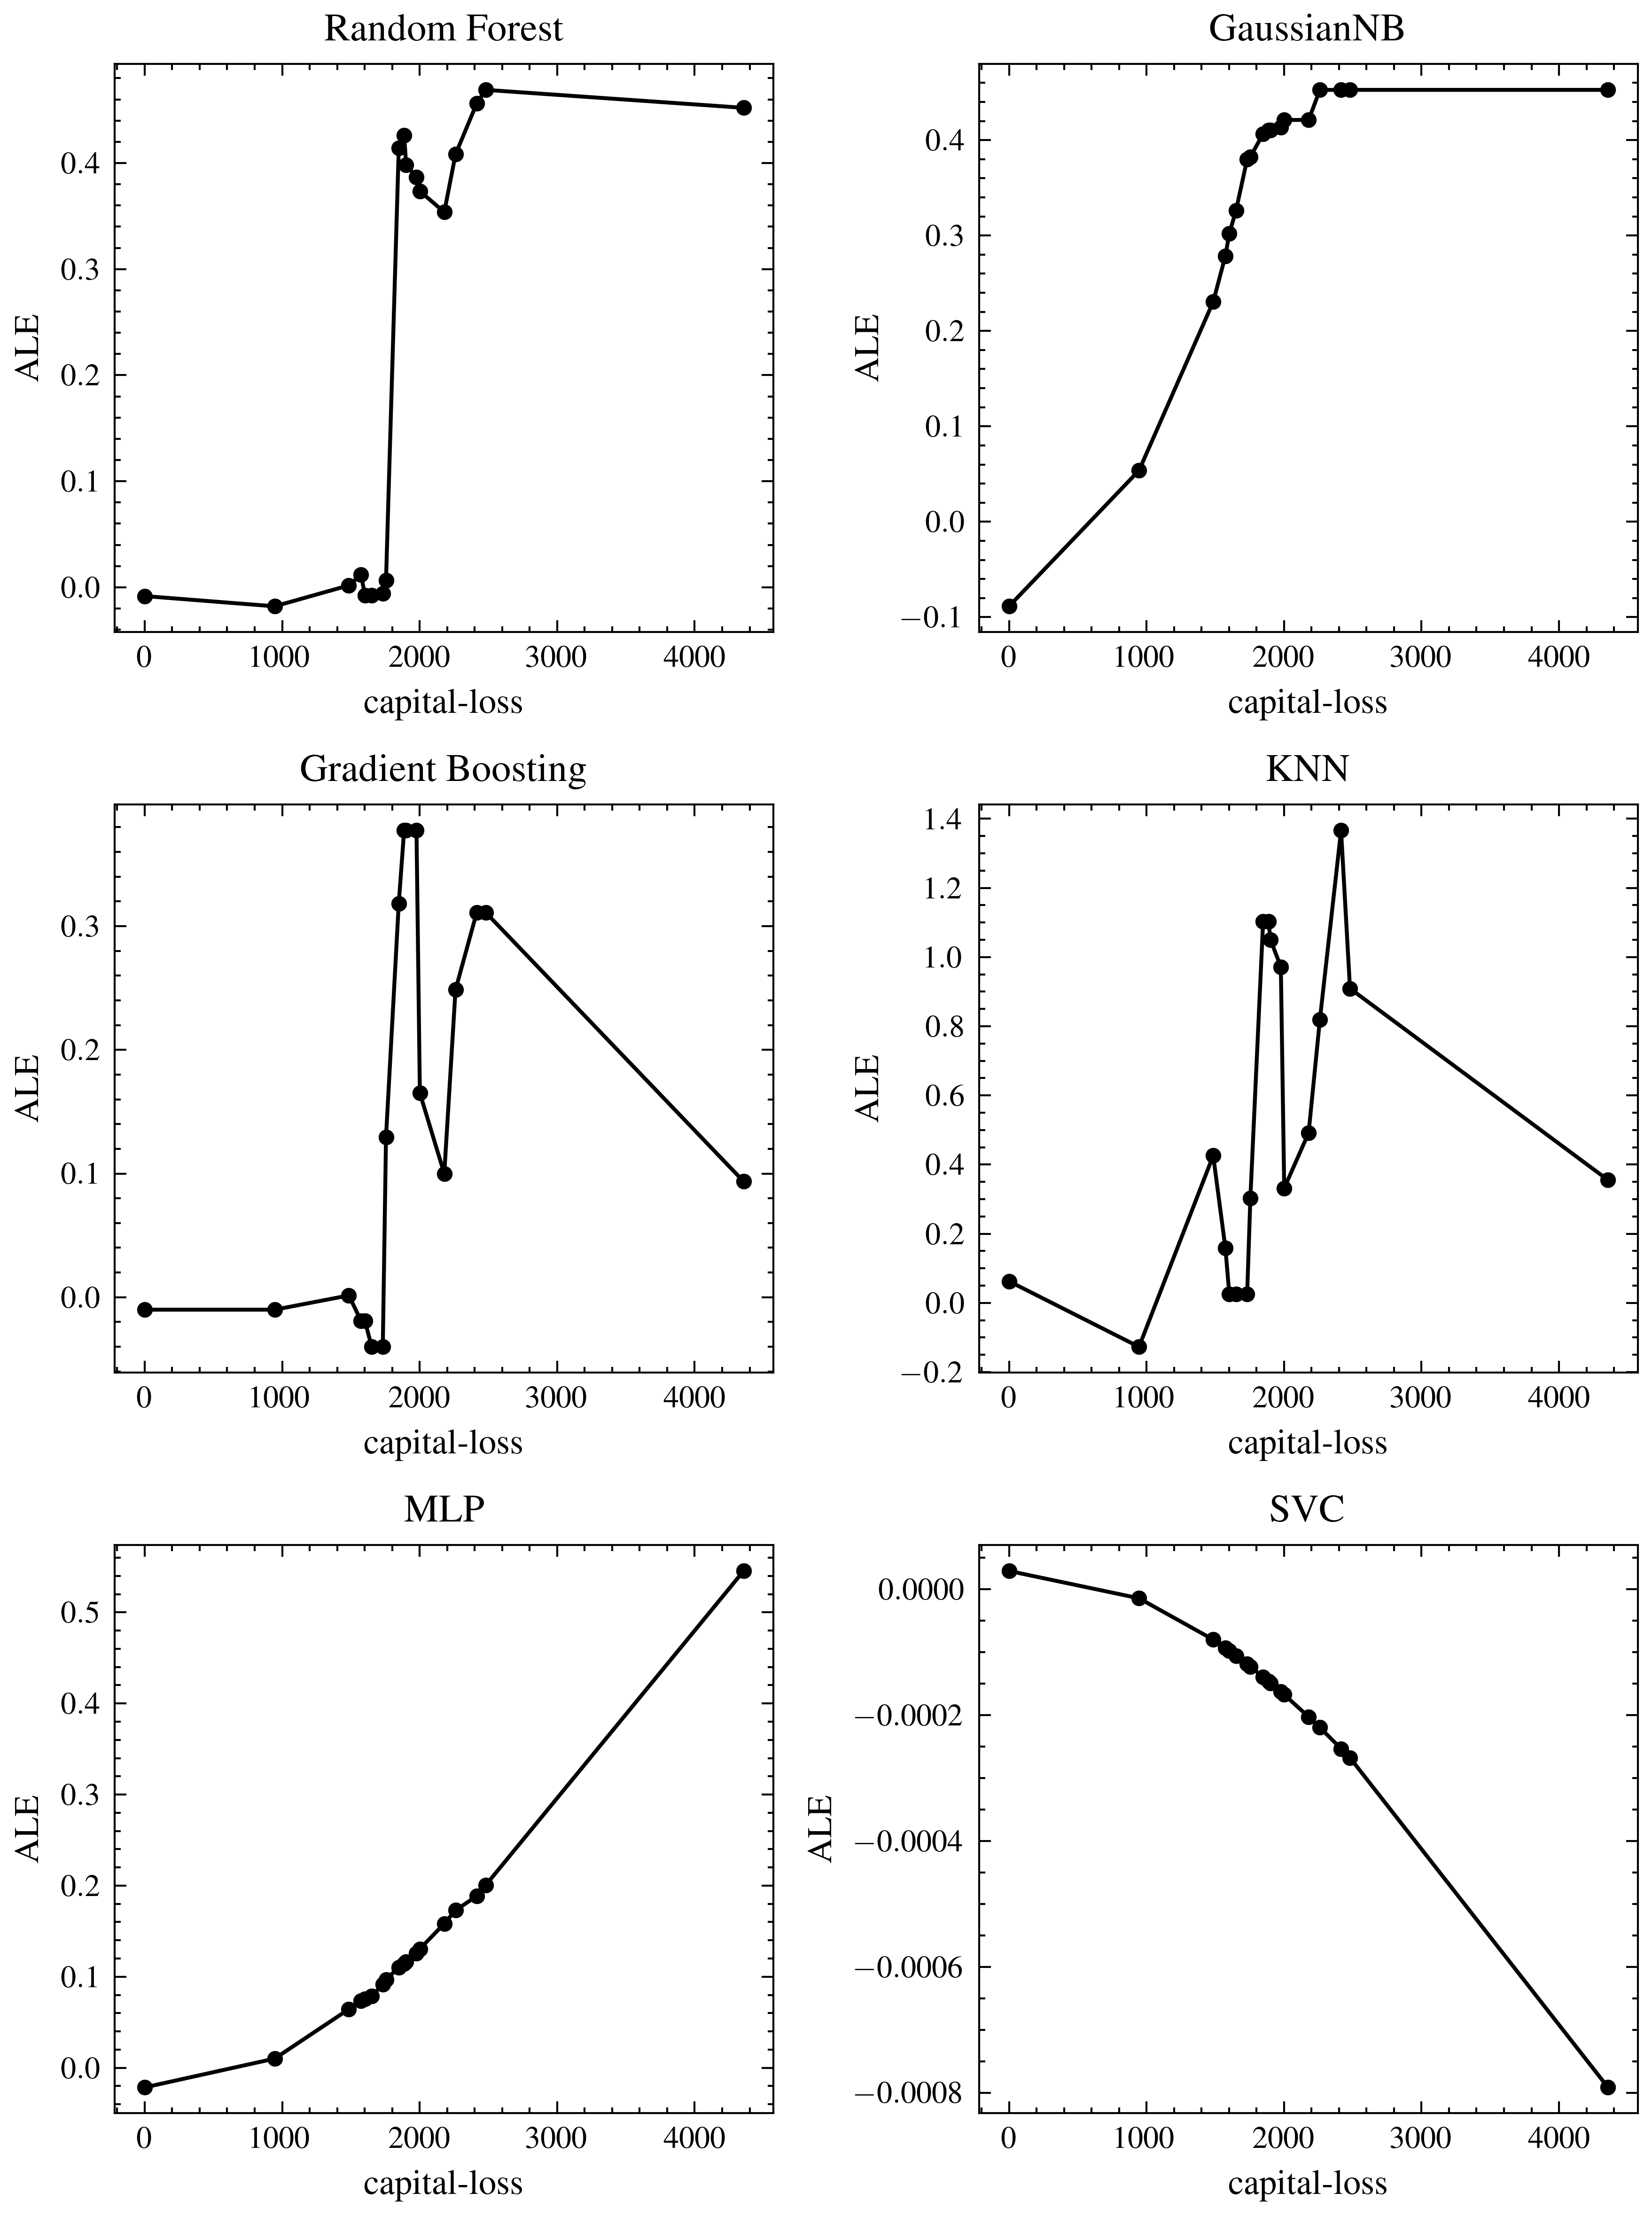

In [36]:
for feature in features:
    plot_ale_for_feature_across_models(X = X_test, predict_fns=predict_fns, feature_names=feature_names, 
                                  feature_name=feature, model_names = model_names)